# Exercise #5: Extrapolation of COVID-19 Infections

### Probabilistic Machine Learning

- **Lecturer**: Prof. Philipp Hennig
- **Term**: SoSe 2020
- **Due Date**: Monday, 25 May 2020

![https://thespinoff.co.nz/society/09-03-2020/the-three-phases-of-covid-19-and-how-we-can-make-it-manageable/](figures/flattenthecurve2.png)

## COVID-19 Time-Series Data

We again consider the number of confirmed infections COVID infections based on the data from the following site:
- https://ourworldindata.org/grapher/total-confirmed-cases-of-covid-19-per-million-people

We first load the provided data from file and retrieve the infection statistics of the US for downstream analysis. Note that infection data are given in cases per million. We will consider the number of infections starting 30 days in from the first reported cases in the dataset.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

# Load data from file
infections_df = pd.read_csv("data/total-confirmed-cases-of-covid-19-per-million-people.csv")

# Select US data
infections_df = infections_df.loc[infections_df['Entity'] == "United States"]
display(infections_df)

# Store US data 
ind = 3
infection_data = infections_df[infections_df.columns[ind]].to_numpy()

# Data 30 days in from the first infection
day0 = 30
infection_data = infection_data[np.where(infection_data>0)[0]][day0:]

,Entity,Code,Date,Total confirmed cases of COVID-19 per million people (cases per million)
10941,United States,USA,"Jan 21, 2020",0.003021
10942,United States,USA,"Jan 22, 2020",0.003021
10943,United States,USA,"Jan 23, 2020",0.003021
10944,United States,USA,"Jan 24, 2020",0.003021
10945,United States,USA,"Jan 25, 2020",0.006042
10946,United States,USA,"Jan 26, 2020",0.006042
10947,United States,USA,"Jan 27, 2020",0.015106
10948,United States,USA,"Jan 28, 2020",0.015106
10949,United States,USA,"Jan 29, 2020",0.015106
10950,United States,USA,"Jan 30, 2020",0.015106


## Probabilistic Model of Infections

### SIR Model 

The [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) is a basic abstraction of the behaviour of an infectious disease transmitted human to human over time. It consists of three main variables:

- $S(t)$: number of **susceptible** individuals
- $I(t)$: number of **infected** individuals
- $R(t)$: number of **recovered**, diseased or immune individuals

The total population is given by $N=S(t) + I(t) + R(t)$, which for simplicity we assume to be constant. Further, we introduce the following variables related to the transition between different states $S$, $I$ and $R$.

- $k$: average number of contacts resulting in an infection
- $\alpha$: fraction of infected individuals recovering (or dying)

![SIR Model](figures/SIR_model.png)

The model is formulated as a set of differential equations describing the change in $S$, $I$ and $R$:
- $\frac{dS}{dt} = - \frac{1}{N}k I S$
- $\frac{dI}{dt} = \frac{1}{N}k I S - \alpha I$
- $\frac{dR}{dt} = \alpha I$

These have the following analytic solution under some simplifying assumptions:
- $S(t) = S(0)\exp(-\xi(t))$
- $I(t) = N - S(t) - R(t)$
- $R(t) = R(0) + N \frac{\alpha}{k} \xi(t)$

where $\xi(t) = \frac{k}{N} \int_{0}^t I(\tau) d\tau$ is the expected number of transmissions an individual has received by time $t$

**Task**: Complete the implementation of a discrete time version of the SIR model. Discrete time in this context means we step forward in time $t$ in discrete steps, where each step corresponds to a day.

In [3]:
def SIR(alpha, k, T, I0=1, R0=0, N=10**6):
    """ 
    Deterministic discrete time SIR model.
    """
    # Setup
    St = np.empty(T)
    It = np.empty(T)
    Rt = np.empty(T)
    xit = np.empty(T)
    St[0] = N - R0 - I0
    It[0] = I0
    Rt[0] = R0
    xit[0] = 0
  
    for t in range(T-1):
        # Expected number of transmissions
        xit[t+1] = k/N*np.sum(It[:t+1])
        
        # Susceptible
        St[t+1] = St[0]*np.exp(-xit[t+1])
        
        # Recovered
        Rt[t+1] = Rt[0] + N*alpha/k*xit[t+1]
        
        # Infectious
        It[t+1] = N - St[t+1] - Rt[t+1]
    
    
    return St, It, Rt, xit

**Task:** Run your SIR model and try to find starting conditions and parameter settings that fit the data reasonably well in the time period from day 30 (after to the first infection) to day 60 by trying different combinations and taking into account the interpretations of the parameters $\alpha$ and $k$.

In [4]:
# Starting conditions
T = 120
I0 = infection_data[0]
alpha = 0.2 # TODO
k =  0.47# TODO

# Toy SIR model
St, It, Rt, xit = SIR(alpha=alpha, k=k, I0=I0, T=T)

The plot below shows the observed number of infections for days 30 to 60 (solid) and day 60 to 100 (dashed) in black. Further the predicted number of susceptible individuals (blue), infected individuals (orange) and recovered or deceased individuals (green) are plotted.

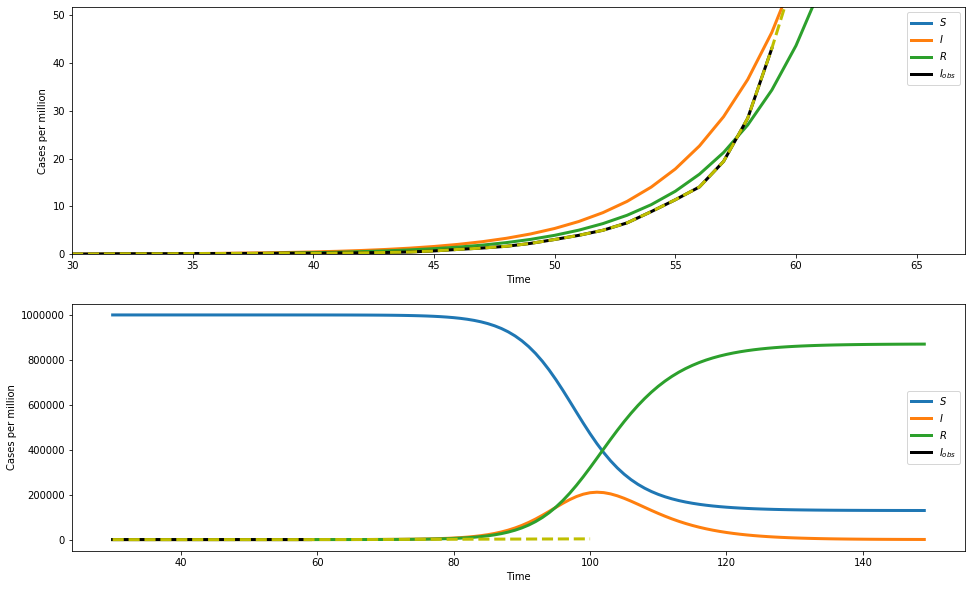

In [5]:
# Plot
%matplotlib inline
import matplotlib.pyplot as plt

# Plot
plot_params = [(St, "$S$"), (It, "$I$"), (Rt, "$R$")]
time = np.arange(T) + day0
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), squeeze=False)

def _plotSIR_helper(i):
    for plot_data, variablename in plot_params:
        axes[i, 0].plot(time, plot_data, label=variablename, linewidth=3)
    axes[i, 0].plot(np.arange(len(infection_data[0:30])) + day0, infection_data[0:30], color="k", label="$I_{obs}$", linewidth=3)
    axes[i, 0].plot(np.arange(len(infection_data)) + day0, infection_data, color="y", linestyle="--", linewidth=3)
    axes[i, 0].set_xlabel("Time")
    axes[i, 0].set_ylabel("Cases per million")
    axes[i, 0].legend()

# Plot observed data timeline
_plotSIR_helper(0)
axes[0, 0].set_ylim([0, max(infection_data[0:30])*1.2])
axes[0, 0].set_xlim([day0, len(infection_data[0:30])+37])
# axes[0, 0].set_ylim([0, 3500])

# Plot entire timeline
_plotSIR_helper(1)
plt.show()

### Probabilistic SIR Model
We now have a discrete approximation to a dynamical model of how the populations of susceptible, infected and recovered individuals relate to each other. Our goal is to **fit** this model to our **observations** and to **predict** the progression of COVID-19 in the future with **uncertainty**. To do this, we transform the above deterministic dynamical model into a probabilistic model, which allows us to condition on our observations. 

We assume the number of infected individuals $I_{\text{obs}}(t)$ we actually observe is noise corrupted.
- $p(I_{\text{obs}}(t) \mid I(t)) = \mathcal{N}(I_{\text{obs}}; I(t), \sigma^2)$, where $\sigma=0.01$

This prior belief is given by the SIR model we just implemented with a given set of initial hyperparameters.

We also model the average number of disease transmissions per person per time as a random variable
- $p(k) = \text{LogNormal}(k; \mu, \sigma^2)$,

where $\mu=-2.8$ and $\sigma=1$.

The LogNormal distribution has a long right tail and describes the distribution of an exponentiated Gaussian random variable. People who are in public offices or critical infrastructure (supermarkets, hospitals, public transport) make up a small fraction of the population, but they have many more contacts than others. Hence a distribution with a long right tail is a sensible modelling choice as there are few people who have the potential to infect a large amount of the population. We will assume that the average number of people an infectious person infects per day is $\mathbb{E}[k] = \exp(\mu + \frac{\sigma^2}{2}) = \exp(-2.8 + \frac{1}{2}) \approx \frac{1}{10}$.

Finally the rate of recovery is modelled as
- $p(\alpha) = \text{Beta}(a; b)$, where $a=1$ and $b=13$.

Our prior assumption being that recovery takes on average $\mathbb{E}[\alpha]^{-1}= \frac{a+b}{a}=14$ days.

### Probabilistic Programming

**Probabilistic programming (PP) languages** are programming languages that **describe probabilistic models** and provide functionality to **perform inference** in those models. Assumptions about variables are encoded as prior distributions. During execution, a probabilistic program will automatically compute the posterior distributions of the parameters of the model based on observed data. _In a nutshell, PP is trying to automate Bayes' theorem as much as possible._ The primary task of the practitioner then becomes the model specification, i.e. specifying a prior and likelihood.

We will use `pyro` for this exercise sheet, which is a Python package. Other popular examples of PP languages are `stan`, `edward`, `PyMC3`, and `infer.NET`.

**Task :** [Install `pyro`](http://docs.pyro.ai/en/stable/installation.html), a probabilistic programming language, which allows us to automate inference.

In [6]:
import torch
import pyro

### Model Implementation in `pyro`

**Task:** Implement the COVID-19 model in `pyro` using the template below. The model describes how we assume the data was generated (likelihood) and our assumptions about the model parameters (prior). Hence for every latent random variable we have to define a `pyro.sample` statement which describes the data generation from the assumed distribution.

In [7]:
def model(prior_params, T, I0, R0=0, N=10**6):
    """ 
    Probabilistic SIR model.
    """
    # Setup
    St = np.empty(T)
    It = np.empty(T)
    Rt = np.empty(T)
    xit = np.empty(T)
    St[0] = N - R0 - I0
    It[0] = pyro.sample("I0", pyro.distributions.Normal(loc=I0, scale=0.01))
    Rt[0] = R0
    xit[0] = 0
    alpha_params = prior_params["alpha"]
    k_params = prior_params["k"]
    
    # Sample from latent variables
    alpha = pyro.sample("alpha", pyro.distributions.Beta(alpha_params[0],
                                                         alpha_params[1]))
    k = pyro.sample("k", pyro.distributions.LogNormal(k_params[0],
                                                      k_params[1])) # TODO
    
    # Discrete time SIR model
    for t in range(T-1):        
        # Expected number of transmissions
        xit[t+1] = k.item()/N*np.sum(It[:t+1]) # TODO
        
        # Susceptible
        St[t+1] = St[0]*np.exp(-xit[t+1]) # TODO
        
        # Recovered
        Rt[t+1] = Rt[0] + N*alpha.item()/k.item()*xit[t+1] # TODO
        
        # Infectious
        It_mean = N - St[t] - Rt[t]
        It[t+1] = pyro.sample(f"I{t+1}", pyro.distributions.Normal(It_mean, 0.01)).item() # TODO

    return St, It, Rt

**Task:** Draw 1000 samples from the prior model by completing the code below using the prior assumptions outlined earlier in the section on the probabilistic SIR model.

In [8]:
pyro.set_rng_seed(42)

# Setup
T = 120
n_samples = 1000
St_prior_samples = np.empty(shape=(n_samples, T))
It_prior_samples = np.empty(shape=(n_samples, T))
Rt_prior_samples = np.empty(shape=(n_samples, T))

# Prior Parameters
alpha_params = [1, 13] # TODO
k_params = [-2.8, 1] # TODO
prior_params = {"alpha": alpha_params, "k": k_params}

# Sampling from the prior predictive model
for i in range(n_samples):
    St_prior_samples[i, :], It_prior_samples[i, :], Rt_prior_samples[i, :] = model(prior_params=prior_params, 
                                                                                   T=T, I0=infection_data[0])

**Task:**: Visualize the prior model's predictions by plotting the means of $S$, $I$ and $R$, 99% credible intervals as well as 100 draws from $I$. Complete the plotting function below to do so.

In [11]:
from scipy import stats
# Plotting function for SIR with credible intervals
def plot_probSIR(St_samples, It_samples, Rt_samples, xlims=None, ylims=None):
    """Plot the SIR model with credible intervals."""
    
    # Means
    St_mean = St_prior_samples.mean(axis=0)
    It_mean = It_prior_samples.mean(axis=0)
    Rt_mean = Rt_prior_samples.mean(axis=0)
    
    # Credible intervals
    St_se = scipy.stats.sem(St_samples, axis = 0)
    It_se = scipy.stats.sem(It_samples, axis = 0)
    Rt_se = scipy.stats.sem(Rt_samples, axis = 0)
    n = len(St_samples)
    
    percentiles = 0.99
    h_St = St_se * scipy.stats.t.ppf((1 + percentiles) / 2., n-1)
    h_It = It_se * scipy.stats.t.ppf((1 + percentiles) / 2., n-1)
    h_Rt = Rt_se * scipy.stats.t.ppf((1 + percentiles) / 2., n-1)
    St_credint = np.vstack((St_mean - h_St, St_mean + h_St))
    It_credint = np.vstack((It_mean-  h_It, It_mean + h_It))
    Rt_credint = np.vstack((Rt_mean - h_Rt, Rt_mean + h_Rt))
    
    
    # Samples
    np.random.seed(42)
    n_samples_plot = 100
    idx = np.random.choice(St_samples.shape[0], n_samples_plot, replace=False) # TODO
    It_samples_plot = It_samples[idx, :]
    
    # Time
    time = np.arange(len(St_mean)) + day0
    
    # Plot
    plot_params = [(St_mean, St_credint, "$S$"), (It_mean, It_credint, "$I$"), (Rt_mean, Rt_credint, "$R$")]
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 10), squeeze=False)
    
    def _plotSIR_helper(i):
        for plot_mean, plot_credint, variablename in plot_params:
#             print(f'plot_mean: {plot_mean.shape}\nplot_cred: {plot_credint.shape}\nvarname: {variablename}')
            axes[i, 0].plot(time, plot_mean, label=variablename, linewidth=3)
            axes[i, 0].fill_between(time, plot_credint[0, :], plot_credint[1, :], alpha=.3, linewidth=3)
            for l in range(n_samples_plot):
                axes[i, 0].plot(time, It_samples_plot[l, :], color="C1", alpha=0.3, linestyle="--")
        axes[i, 0].plot(np.arange(len(infection_data[0:30])) + day0, infection_data[0:30], color="k", label="$I_{obs}$", linewidth=3)
        axes[i, 0].plot(np.arange(len(infection_data)) + day0, infection_data, color="k", linestyle="--", linewidth=3)
        axes[i, 0].set_xlabel("Time")
        axes[i, 0].legend()
    
    # Plot observed data timeline
    _plotSIR_helper(0)
    if xlims is None:
        xlims = [day0, len(infection_data) + 7 + day0]
    if ylims is None:
        ylims = [0, max(infection_data) * 1.1]
    axes[0, 0].set_xlim(xlims)
    axes[0, 0].set_ylim(ylims)

    # Plot entire timeline
    _plotSIR_helper(1)
    plt.show()
   

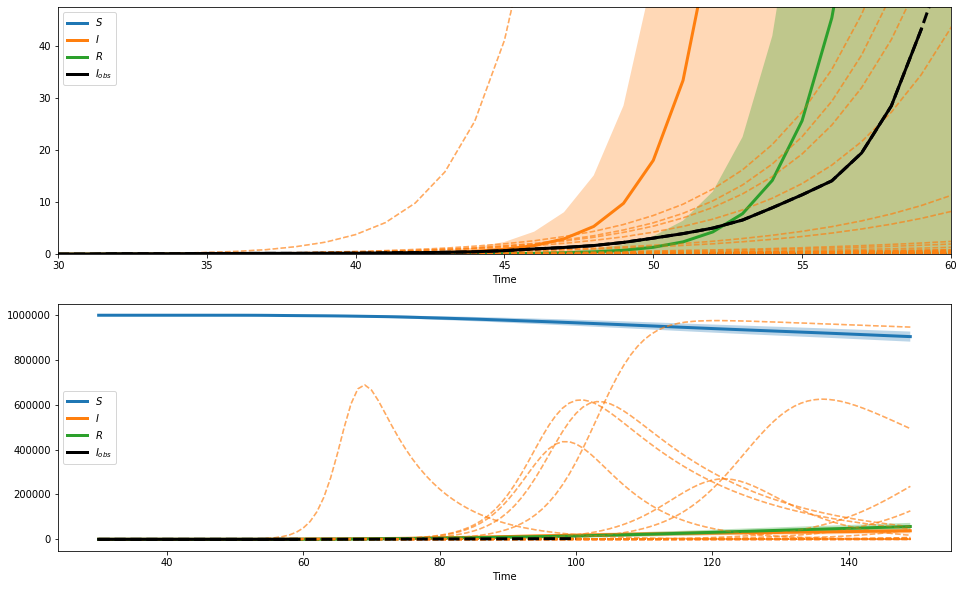

In [12]:
# Plot prior model
plot_probSIR(St_prior_samples, It_prior_samples, Rt_prior_samples, 
             xlims=[day0, day0+30], ylims=[0, max(infection_data[0:30]) * 1.1])

**Task:** Given your experimentation with the deterministic SIR model and the prior assumptions for the probabilistic model, answer the following questions:

Are the prior distributions for $k$ and $\alpha$ good assumptions based on the data of days 30 to 60 (in solid black)?
- The distributions look fairly sensible in terms of rate of growth (considering span 30 - 60 days) but not in the actual values/fitting the curve.

How do the prior means for $k$ and $\alpha$ compare to the parameters you found when experimenting with the deterministic model? Why could they be different?
- They are different because I tweaked my parameters to fit the data I observed (which is the wrong way to design the prior I believe) while I assume that the prior knowlegde you had was more general.

### Conditioning on Data

We now condition our model on the actual number of infections observed from day 30 to day 60.

In [13]:
# Put data into dictionary with named labels
infection_data_30to60 = infection_data[0:30]
keys = ["I{}".format(str(i)) for i in range(len(infection_data_30to60))]
infection_data_dict = dict(zip(keys, torch.tensor(infection_data_30to60)))

# Condition probabilistic model on data
conditioned_model = pyro.condition(model, data=infection_data_dict)

### Inference via MCMC

We have specified a model in a probabilistic programming language consisting of our prior assumptions about how the data was generated and the actual observations. This now allows us to infer the posterior distributions over the latent parameters. We will do so via a flavor of Hamiltonian MCMC implemented as part of the MCMC samplers in `pyro`.

_Note:_ The MCMC sampling might take a few minutes depending on your machine. For some comic relief in the meantime check out: https://twitter.com/chelseaparlett/status/1250787601641910285?lang=en

In [14]:
import warnings
warnings.filterwarnings('ignore')
pyro.set_rng_seed(42)

# Sample 10000 realizations from the posterior via MCMC
n_samples_mcmc = 10000

# No-U-turn sampling kernel
nuts_kernel = pyro.infer.NUTS(model=conditioned_model, adapt_step_size=True, jit_compile=True, max_tree_depth = 6)
mcmc_sampler = pyro.infer.MCMC(nuts_kernel, num_samples=n_samples_mcmc, num_chains=1, warmup_steps=200)

# Run MCMC sampler and get samples
mcmc_sampler.run(prior_params=prior_params, T=len(infection_data_30to60), I0=infection_data[0])
posterior_samples = mcmc_sampler.get_samples(n_samples_mcmc)

Sample: 100%|██████████| 10200/10200 [01:10, 145.65it/s, step size=7.92e-01, acc. prob=0.926]


We want to diagnose the MCMC run to get an idea whether we should trust the generated samples, i.e. whether they represent a sample from the true posterior over the parameters.

In [15]:
# MCMC summary
mcmc_sampler.summary(prob=0.95)


                mean       std    median      2.5%     97.5%     n_eff     r_hat
     alpha      0.07      0.07      0.05      0.00      0.21   7324.61      1.00
         k      0.10      0.14      0.06      0.00      0.32   6459.17      1.00

Number of divergences: 0


**Task**: Generate kernel density estimates and trace plots for the parameters $k$ and $\alpha$. Based on your plots and the summary statistics, do you think the Markov chain mixed well and the run was successful?

In [16]:
import scipy.stats

def trace_plot(params):
    """
    Generate trace plots for the given parameters.
    
    params : dict
        Dictionary of inferred parameters containing MCMC samples as values.
    """
    
    # Initialization
    n_params = len(params)
    fig, axes = plt.subplots(nrows=n_params, ncols=2, figsize=(16,5), squeeze=False)
    
    for i, (param, param_samples) in enumerate(params.items()):
        # Kernel density estimate
        kernel = scipy.stats.gaussian_kde(param_samples) # TODO
        xx = np.linspace(min(param_samples), max(param_samples), num=1000)
        axes[i, 0].plot(xx, kernel(xx))
        axes[i, 0].set_ylabel(param)
        axes[i, 0].set_yticklabels([])
        axes[i, 0].set_yticks([])

        # Trace Plot
        axes[i, 1].plot(param_samples)
        

    axes[0, 0].set_title("Kernel Density Estimate")
    axes[0, 1].set_title("Trace Plot")
        
    plt.show()

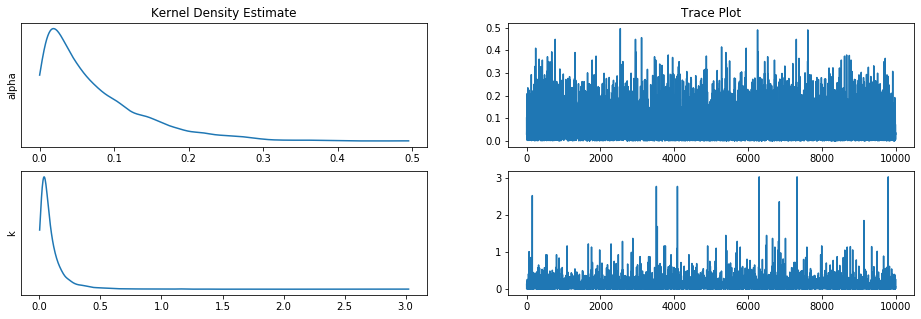

In [17]:
# Trace plot of MCMC run
param_dict = {"alpha": posterior_samples["alpha"].numpy(),
              "k": posterior_samples["k"].numpy()}
trace_plot(param_dict)

_Your comment:_ I think it has mixed successfully as the trace plots show that the sampler has explored distribution well (we can see that there are no flat regions where it was stuck etc.)

### Predictive Distribution
In order to compute the predictive distribution we evaluate the SIR model with the latent variables $\alpha$ and $k$ set to the values sampled from the posterior distribution.

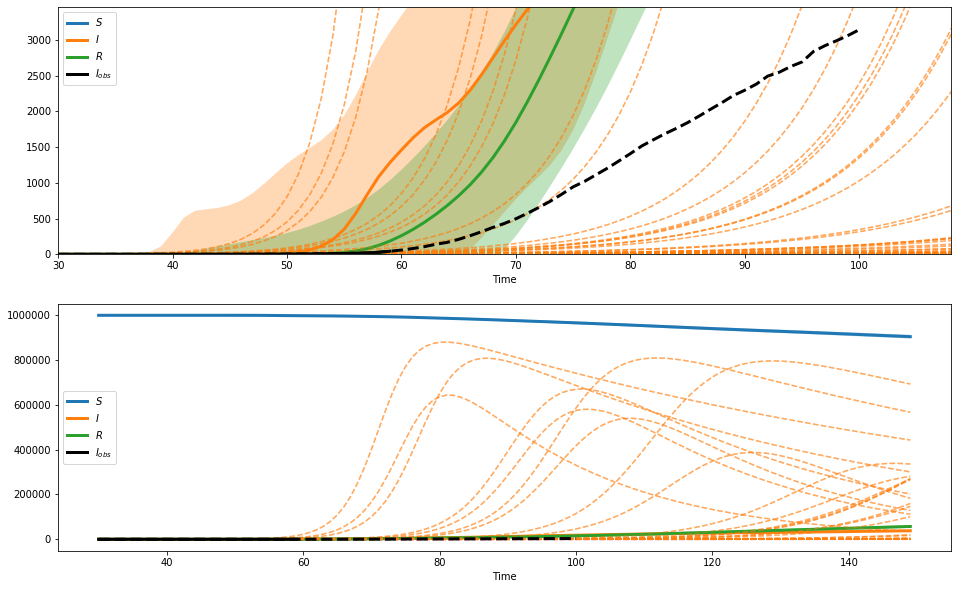

In [18]:
# Setup
St_pred_samples = np.empty(shape=(n_samples_mcmc, T))
It_pred_samples = np.empty(shape=(n_samples_mcmc, T))
Rt_pred_samples = np.empty(shape=(n_samples_mcmc, T))

# Compute samples from posterior predictive distribution
for i, (alpha, k) in enumerate(zip(posterior_samples["alpha"].numpy(), posterior_samples["k"].numpy())):
    St_pred_samples[i, :], It_pred_samples[i, :], Rt_pred_samples[i, :], _ = SIR(T=T, R0=0, 
                                                                                 alpha=alpha, k=k)

# Plot posterior model
plot_probSIR(St_pred_samples, It_pred_samples, Rt_pred_samples)

## Interpretation

**Task:** Based on the results you obtained answer the questions below.

### Result Interpretation
How does the posterior predictive distribution compare to the prior predictive distribution? Does the result correspond to what you would expect?
- Mean has changed towards the observations. It does correspond to the expectation, but not fully as I expected much better fit.

Is the mean prediction of the model an informative proxy for what the actual number of infections are after day 60. If not, why do you think this is?
- It is not as it is still biased (way much) towards prior. Maybe according to the data, SIR model wasn't able to adjust.

What can you say about the SIR model's sensitivity to the parameter choices of $\alpha$ and $k$ based on the uncertainty in the posterior predictive model?
- Generally SIR model is very sensitive on changing the calues of $\alpha$ and $k$ (which can be observed by changing the values and plotting) but I am not sure how does the uncertainty of posterior change this in any way? The thing we can say though is that the posterior model is reather certain in the choice of the parameters it picked.

Do you think the vanilla deterministic/probabilistic SIR model is a good model for the COVID-19 infection numbers in the US?
- I think it's fairly simple and thus could be improved.

### Model Improvement
Given the above model, what additional data would you collect to improve the predictions from your model?
- Assuming that the SIR part of the model could be changed, I would gather the data that would enable the extention of the model described below. 

How would you augment the probabilistic model to make it more realistic?
- Include the information about people in quarantine, restrictive meassures etc. individual recovery power and movement model.

**Image Sources**:
- Wiles, Siouxsie and Morris, Toby. https://thespinoff.co.nz/society/09-03-2020/the-three-phases-of-covid-19-and-how-we-can-make-it-manageable/

**References**:
- Pyro documentation: http://docs.pyro.ai/en/stable/
